# Literary embeddings and topic models for prediction and visualization

Notebook for the paper "Vector Space Explorations of Literary Language"

In [1]:
%matplotlib inline
import io
import os
import re
import random
import textwrap
from functools import reduce
from operator import or_
from collections import Counter, OrderedDict
import numpy as np
from scipy.spatial.distance import cosine, euclidean
import pandas
import gensim
from sklearn import (metrics, linear_model, feature_extraction, model_selection,
        manifold, preprocessing, decomposition, neighbors)
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn

SEED = 42  # fix random seed

In [2]:
# Load data/models
import features
docs, docslemma, y, index = features.readchunks()

x_uni, names, unigrams = features.load_sparse_mat('unigram.npz')
x_bi, _names, bigrams = features.load_sparse_mat('bigram.npz')
x_d2v = pandas.read_csv('d2v.csv', index_col=0)
x_lda = pandas.read_table('/datastore/avcrane1/Riddle/newchunks/lda/doctopics.txt',
        index_col=0, header=None, usecols=range(1, 52), skiprows=1,
        names=['Filename'] + ['t%d' % n for n in range(50)])
split = x_lda.index.str.rsplit('_', n=1)
x_lda.index = split.str[0] + ' ' + split.str[1]
x_comb = pandas.concat([x_lda, x_d2v], axis=1, ignore_index=True)

# Load the trained models
d2v = gensim.models.doc2vec.Doc2Vec.load('doc2vecmodel.bin')

# Metadata: prediction targets
%cd /datastore/avcrane1/Riddle
md = pandas.read_csv('metadata.csv', index_col=0)
newmd = pandas.read_csv('metadata_notread.csv', index_col=0)
y = pandas.Series(y, index=names)

%cd /datastore/avcrane1/literariness/Riddle/
target = pandas.read_csv('features/target.csv', index_col=0)
# folds = pandas.Series([target.at[label.rsplit(' ', 1)[0], 'fold'] for label in names], index=names)
folds = []  # folds[0]: binary mask of all chunks in fold 0
# folds[0] can be used as test set, with ~folds[0] equivalent to folds[1:5] as train set.
# NB: ~folds[0] does include books not assigned to any folds due to rating/#sentences.
for n in sorted(target.fold.unique()):
    labelsinfold = target[target.fold == n].index
    folds.append(np.array([label.rsplit(' ', 1)[0] in labelsinfold
                   for label in names], np.bool))

2018-07-26 17:47:52,198 : INFO : loading Doc2Vec object from doc2vecmodel.bin
2018-07-26 17:47:53,415 : INFO : loading vocabulary recursively from doc2vecmodel.bin.vocabulary.* with mmap=None
2018-07-26 17:47:53,416 : INFO : loading trainables recursively from doc2vecmodel.bin.trainables.* with mmap=None
2018-07-26 17:47:53,417 : INFO : loading syn1neg from doc2vecmodel.bin.trainables.syn1neg.npy with mmap=None
2018-07-26 17:47:53,448 : INFO : loading wv recursively from doc2vecmodel.bin.wv.* with mmap=None
2018-07-26 17:47:53,450 : INFO : loading vectors from doc2vecmodel.bin.wv.vectors.npy with mmap=None
2018-07-26 17:47:53,479 : INFO : loading docvecs recursively from doc2vecmodel.bin.docvecs.* with mmap=None
2018-07-26 17:47:53,481 : INFO : loading vectors_docs from doc2vecmodel.bin.docvecs.vectors_docs.npy with mmap=None
2018-07-26 17:47:53,499 : INFO : loaded doc2vecmodel.bin


/datastore/avcrane1/Riddle
/datastore/avcrane1/literariness/Riddle


In [3]:
def evalreport(y_true, y_pred, folds, mask=None):
    """Given two Series objects and a sequence 'folds', compute metrics for each
    fold and report mean/stderr."""
    if mask is None:
        mask = np.ones(len(names), np.bool)
    result = pandas.DataFrame(index=['mean', 'std err'])
    # NB: calculate mean of MSE of each fold, then take root of overall
    # mean. http://stats.stackexchange.com/a/85517
    mse = pandas.Series([metrics.mean_squared_error(y_true[a & mask], y_pred[a & mask])
            for a in folds])
    r2 = pandas.Series([metrics.r2_score(y_true[a & mask], y_pred[a & mask])
            for a in folds])
    tau = pandas.Series([y_true[a & mask].corr(y_pred[a & mask], method='kendall')
            for a in folds])
    result['$R^2$'] = 100 * pandas.Series([
            r2.mean(), r2.sem()], index=result.index)
    result[r'Kendall $\tau$'] = pandas.Series([
            tau.mean(), tau.sem()], index=result.index)
    result['RMS error'] = (pandas.Series([
            mse.mean(), mse.sem()], index=result.index) ** 0.5)
    return result.T

def evalpred(predmodel, data, y, mask=None):
    if mask is None:
        mask = np.ones(len(names), np.bool)
    y_pred = pandas.Series(index=names, name='prediction')
    for n, fold in enumerate(folds):
        otherfolds = reduce(or_, [a for m, a in enumerate(folds) if m != n])
        predmodel.fit(data[otherfolds & mask], y[otherfolds & mask])
        y_pred[fold & mask] = predmodel.predict(data[fold & mask])
    return evalreport(y, y_pred, folds, mask).round(decimals=3), y_pred

def labeledscatterplot(xdata, lines=False, label=None, marker=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 11))
    xdata.plot.scatter(x=xdata.columns[0], y=xdata.columns[1], ax=ax,
                            c=xdata['color'] if 'color' in xdata.columns else None,
                            marker=marker or 'o', label=label)
    if lines:
        plt.plot(xdata.iloc[:, 0], xdata.iloc[:, 1], c='gray')
    for k, v in xdata.iterrows():
        ax.annotate(k, v[:2],
                    xytext=(5, -5), textcoords='offset points',
                    family='sans-serif', fontsize=8, color='darkslategrey')
    return ax

In [4]:
# Avg # words in chunks
pandas.Series([len(doc.words) for doc in docs]).describe()

count    52107.000000
mean      1000.247606
std          7.347068
min        791.000000
25%        997.000000
50%       1000.000000
75%       1004.000000
max       1202.000000
dtype: float64

## Supervised predictive models

In [5]:
# BoW unigrams, binary
param_grid = dict(alpha=[10.0, 1.0, 1e-1, 1e-3, 1e-4, 1e-6])
estimator = linear_model.SGDRegressor(
        loss='epsilon_insensitive', random_state=SEED, max_iter=int(10 ** 6 / (0.8 * len(docs))))
predmodel = model_selection.GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=16)
evalpred(predmodel, x_uni != 0, y)[0]

,mean,std err
$R^2$,35.527,1.508
Kendall $\tau$,0.397,0.018
RMS error,0.786,0.128


In [6]:
# BoW bigrams, binary
param_grid = dict(alpha=[10.0, 1.0, 1e-1, 1e-3, 1e-4, 1e-6])
estimator = linear_model.SGDRegressor(
        loss='epsilon_insensitive', random_state=SEED, max_iter=int(10 ** 6 / (0.8 * len(docs))))
predmodel = model_selection.GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=16)
evalpred(predmodel, x_bi != 0, y)[0]

,mean,std err
$R^2$,33.746,4.826
Kendall $\tau$,0.395,0.031
RMS error,0.797,0.217


In [7]:
# LDA, unigrams (lemmas)
predmodel = linear_model.RidgeCV(alphas=[10.0, 1.0, 1e-1, 1e-3, 1e-4, 1e-6])
evalpred(predmodel, x_lda, y)[0]

,mean,std err
$R^2$,47.133,2.851
Kendall $\tau$,0.488,0.020
RMS error,0.712,0.157


In [8]:
# PV DBoW doc2vec
predmodel = linear_model.RidgeCV(alphas=[10.0, 1.0, 1e-1, 1e-3, 1e-4, 1e-6])
evalpred(predmodel, x_d2v, y)[0]

,mean,std err
$R^2$,42.908,2.173
Kendall $\tau$,0.455,0.020
RMS error,0.740,0.144


In [9]:
# combination of lda+d2v
predmodel = linear_model.RidgeCV(alphas=[10.0, 1.0, 1e-1, 1e-3, 1e-4, 1e-6])
evalpred(predmodel, x_comb, y)[0]

,mean,std err
$R^2$,52.152,1.674
Kendall $\tau$,0.511,0.021
RMS error,0.677,0.100


In [10]:
# Apply combination to different target variables
# NB: the "not read" variables have much less ratings
# NB2: different score for "Literary rating" because books with less than 50 ratings are included.
targets = ['Literary rating', 'Literary rating not read', 'Quality rating', 'Quality rating not read']
targetnums = ['# literary ratings', '# literary ratings not read', '# quality ratings', '# quality ratings not read']
result = []
preddf = []
for var, num in zip(targets, targetnums):
    predmodel = linear_model.RidgeCV(alphas=[10.0, 1.0, 1e-1, 1e-3, 1e-4, 1e-6])
    y_ = pandas.Series([newmd.at[label.split()[0], var] for label in names], index=names, name=var)
    mask = np.array([newmd.at[label.split()[0], num] >= 1 for label in names], np.bool)
    df, y_pred = evalpred(predmodel, x_comb, y_, mask)
    result.append(df.stack())
    preddf.append((y_[y_pred.notnull()], y_pred[y_pred.notnull()]))
pandas.DataFrame(result, index=targets).round(3)

$R^2$         Kendall $\tau$         RMS error  \
                            mean std err           mean std err      mean   
Literary rating           51.917   1.580          0.511   0.021     0.682   
Literary rating not read  37.032   2.698          0.431   0.017     1.029   
Quality rating            23.911   2.818          0.343   0.014     0.378   
Quality rating not read   21.612   3.560          0.324   0.023     0.919   

                                  
                         std err  
Literary rating            0.093  
Literary rating not read   0.222  
Quality rating             0.143  
Quality rating not read    0.162

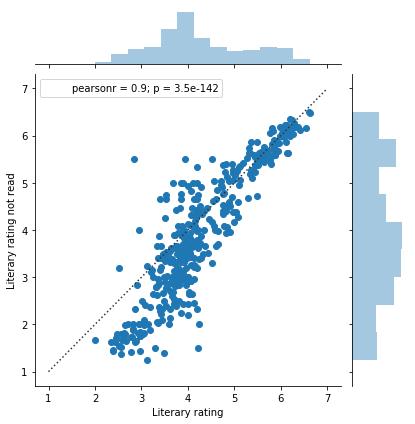

In [11]:
jg = seaborn.jointplot('Literary rating', 'Literary rating not read', data=newmd)
jg.fig.axes[0].plot([1, 7], [1, 7], ls=':', c='.2')
jg.fig.savefig('/tmp/litreadcorr.pdf')

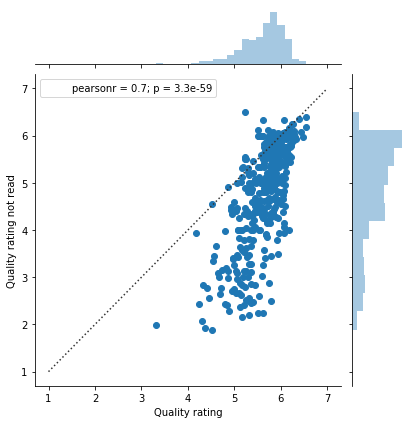

In [12]:
jg = seaborn.jointplot('Quality rating', 'Quality rating not read', data=newmd)
jg.fig.axes[0].plot([1, 7], [1, 7], ls=':', c='.2')
jg.fig.savefig('/tmp/qualreadcorr.pdf')

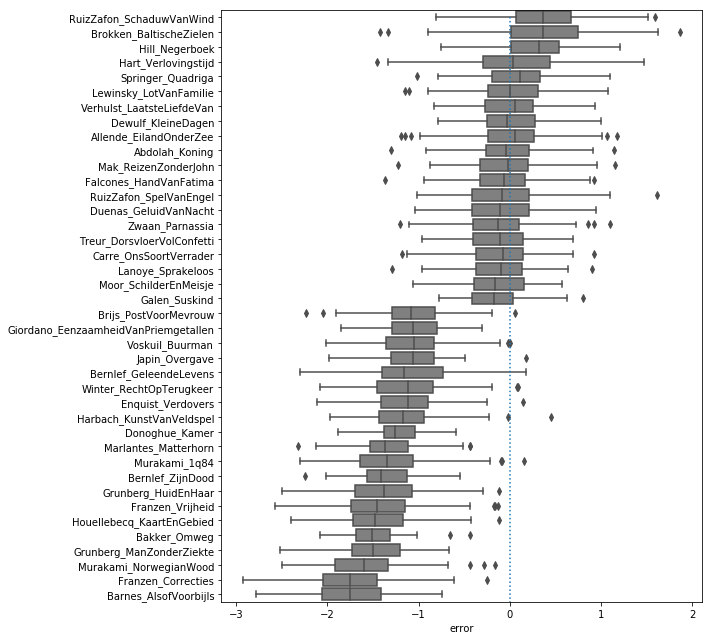

In [13]:
y_true, y_pred = preddf[0]
df = pandas.DataFrame({
             'error': y_pred - y_true,
             'rating': y_true,
             'label': [label.split()[0] for label in y_true.index]},
             index=y_true.index
             )
df.index = pandas.MultiIndex.from_tuples([label.split() for label in y_true.index])

errorsminmax = pandas.DataFrame(
        [df.error[a].describe() for a in df.index.levels[0]],
        index=df.index.levels[0])
errorsminmax = errorsminmax[errorsminmax['count'] > 30]  # filter short novels
errorsminmax.sort_values('mean', inplace=True, ascending=False)

n = 20
selection = md[md['Literary rating'] > 5].index
selection = [a for a in errorsminmax.index if a in selection]
selection = selection[:n] + selection[-n:]
fig, ax = plt.subplots(figsize=(10, 9))
seaborn.boxplot(data=df, y='label', x='error', orient='h', ax=ax, color='gray',
                order=selection)
ax.plot([0, 0], [0, len(df)], ls=':')
ax.set_ylabel('')
fig.tight_layout(); fig.savefig('/tmp/errorboxplots.pdf')

## Semantic complexity

In [14]:
def bookvariance(label):
    """Measure variance of novel chunks in doc2vec model:
    
    - compute centroid for each book (mean of chunk vectors);
    - compute distances to centroid of each chunk (1 - similarity);
    - return mean of squared distances (as in K-means clustering)."""
    df = x_comb.loc[x_comb.index.str.startswith(label), :]
    centroid = df.mean(axis=0)
    distances = metrics.pairwise.euclidean_distances(df, [centroid])
    return (distances ** 2).mean()

def bookstepwisedist(label):
    """Measure average distance of consecutive novel chunks in doc2vec model:
    
    - compute distances of chunks (n, n+1);
    - return mean of squared distances."""
    df = x_comb.loc[x_comb.index.str.startswith(label), :]
    distances = pandas.Series([euclidean(df.iloc[y], df.iloc[y + 1]) for y in range(len(df) - 1)])
    return (distances ** 2).mean()

centroids = x_comb.set_index(x_comb.index.str.split(' ', n=0, expand=True)).mean(level=0)

def outlierscore(label):
    """Measure degree to wich a book is an anomaly/outlier compared to other books.
    
    Implemented as the distance to the nearest neighbor, based on centroids of books."""    
    distances = metrics.pairwise.euclidean_distances(
            centroids.loc[centroids.index != label, :],
            centroids.loc[centroids.index == label, :])
    return distances.min()
    # instead of nearest neighbor, can consider the kth nearest neighbor:
    # return sorted(distances.flatten())[3]

tree = neighbors.BallTree(x_comb.values, metric='euclidean')
def overlapscore(label):
    """A measure of the overlap between the chunks of a novel with other novels. """
    thisbook = x_comb.loc[x_comb.index.str.startswith(label), :]
    # take centroid, ask for N nearest neighbors, with N number of chunks in novel
    indices = tree.query([centroids.loc[label, :]], len(thisbook), return_distance=False)[0]
    # return fraction of neighbors that are part of other novels
    return sum(not names[a].startswith(label) for a in indices) / float(len(indices))

y_true, y_pred = preddf[0]

def bookprederror(label):
    """Root mean squared error (RMSE) of the chunks of a given novel."""
    return metrics.mean_squared_error(
            y_true[y_true.index.str.startswith(label)],
            y_pred[y_pred.index.str.startswith(label)]) ** 0.5

In [15]:
variances = pandas.DataFrame({
    'Literary rating': md.loc[target.index, 'Literary rating'],
    'variance': [bookvariance(a) for a in target.index],
    'stepwisedist': [bookstepwisedist(a) for a in target.index],
    'outlier_score': [outlierscore(a) for a in target.index],
    'overlap_score': [overlapscore(a) for a in target.index],
    },
    index=target.index)

In [16]:
for a in variances.columns[1:]:
    # manually add '\dots' between top & bottom 5.
    print(pandas.concat([
        variances[['Literary rating', a]].sort_values(a).head(),
        variances[['Literary rating', a]].sort_values(a).tail()]).round(3).to_latex())
    print()

\begin{tabular}{lrr}
\toprule
{} &  Literary rating &  variance \\
Label                   &                  &           \\
\midrule
Slee\_FataleLiefde       &            4.141 &     8.219 \\
Rendell\_Dief            &            4.212 &     8.516 \\
Slee\_BangkokBoy         &            3.524 &     8.528 \\
Groningen\_Misleid       &            3.260 &     8.715 \\
Voskuil\_Buurman         &            6.053 &     8.780 \\
Buwalda\_BonitaAvenue    &            5.844 &    15.683 \\
Mak\_ReizenZonderJohn    &            5.059 &    15.727 \\
Dorrestein\_Leesclub     &            4.977 &    15.820 \\
Brokken\_BaltischeZielen &            5.579 &    16.393 \\
Lanoye\_Sprakeloos       &            6.373 &    16.415 \\
\bottomrule
\end{tabular}


\begin{tabular}{lrr}
\toprule
{} &  Literary rating &  stepwisedist \\
Label                   &                  &               \\
\midrule
Slee\_FataleLiefde       &            4.141 &        13.880 \\
Slee\_BangkokBoy         &            3.524

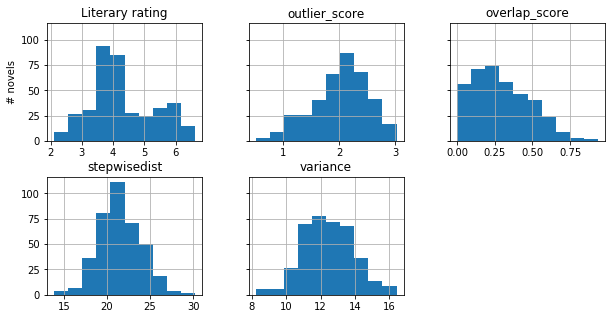

In [17]:
# histograms of semantic complexity measures
axes = variances.hist(layout=(2, 3), figsize=(10, 5), sharey=True);
axes[0, 0].set_ylabel('# novels');

In [18]:
# Correlations for semantic complexity
pandas.Series([variances['Literary rating'].corr(variances[a]) for a in variances.columns],
    index=variances.columns)

Literary rating    1.000000
variance           0.340916
stepwisedist       0.431384
outlier_score      0.337848
overlap_score     -0.200422
dtype: float64

In [19]:
variances.to_csv('/datastore/avcrane1/deeplit.new/semcomplexity.csv')

In [20]:
variances[variances.index.str.startswith('Lanoye')]

,Literary rating,variance,stepwisedist,outlier_score,overlap_score
Label,,,,,
Lanoye_HeldereHemel,5.825879,15.522018,28.278615,1.990556,0.642857
Lanoye_Sprakeloos,6.372765,16.415300,30.014279,1.877296,0.715596


In [21]:
# Find the novels that overlap with this novel
label = 'Lanoye_Sprakeloos'
thisbook = x_comb.loc[x_comb.index.str.startswith(label), :]
indices = tree.query([centroids.loc[label, :]], len(thisbook), return_distance=False)[0]
Counter([names[a].rsplit(' ')[0] for a in indices if not names[a].startswith(label)]).most_common(10)

[('Mortier_GestameldLiedboek', 13),
 ('Japin_Vaslav', 7),
 ('Krauss_GroteHuis', 6),
 ('Beijnum_SoortFamilie', 5),
 ('Dewulf_KleineDagen', 4),
 ('Thomese_Weldoener', 4),
 ('Kroonenberg_Familieblues', 4),
 ('Verhulst_LaatsteLiefdeVan', 3),
 ('Mankell_DaisySisters', 3),
 ('Moor_NederlandseMaagd', 2)]

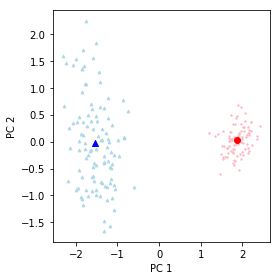

In [22]:
fig, ax = plt.subplots(figsize=(4, 4))
a = 'Slee_FataleLiefde'
b = 'Wieringa_Caesarion'
df = x_comb.loc[x_comb.index.str.startswith(a) | x_comb.index.str.startswith(b), :]
pca = decomposition.PCA(2)
red = pca.fit_transform(df)
centroids = pca.transform([x_comb.loc[x_comb.index.str.startswith(a)].mean(),
        x_comb.loc[x_comb.index.str.startswith(b)].mean()])
xdata = pandas.DataFrame(red, index=df.index)
aa = xdata[df.index.str.startswith(a)]
bb = xdata[df.index.str.startswith(b)]
aa.plot.scatter(x=xdata.columns[0], y=xdata.columns[1], ax=ax, c='LightPink', marker='.', s=7)
bb.plot.scatter(x=xdata.columns[0], y=xdata.columns[1], ax=ax, c='LightBlue', marker='^', s=7)
ax.scatter(x=centroids[0, 0], y=centroids[0, 1], c='r', marker='o')
ax.scatter(x=centroids[1, 0], y=centroids[1, 1], c='b', marker='^')
ax.set_ylabel('PC 2'); ax.set_xlabel('PC 1'); fig.tight_layout(); 
fig.savefig('/tmp/exvariance.pdf')

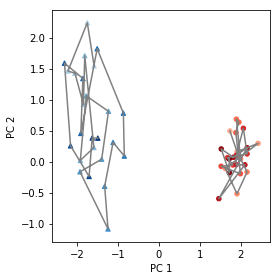

In [23]:
fig, ax = plt.subplots(figsize=(4, 4))
a = 'Slee_FataleLiefde'
b = 'Wieringa_Caesarion'
df = x_comb.loc[x_comb.index.str.startswith(a) | x_comb.index.str.startswith(b), :]
pca = decomposition.PCA(2).fit_transform(df)
xdata = pandas.DataFrame(pca, index=df.index)
aa = xdata[df.index.str.startswith(a)].iloc[:25, :]
bb = xdata[df.index.str.startswith(b)].iloc[:25, :]
plt.plot(aa.iloc[:, 0], aa.iloc[:, 1], c='gray')
plt.plot(bb.iloc[:, 0], bb.iloc[:, 1], c='gray')
aa.plot.scatter(x=xdata.columns[0], y=xdata.columns[1], ax=ax, #label=a,
        c=plt.cm.Reds(plt.Normalize(vmin=-10, vmax=25)(range(len(aa)))))
bb.plot.scatter(x=xdata.columns[0], y=xdata.columns[1], ax=ax, marker='^', #label=b,
        c=plt.cm.Blues(plt.Normalize(vmin=-10, vmax=25)(range(len(bb)))))
ax.set_ylabel('PC 2'); ax.set_xlabel('PC 1'); fig.tight_layout();#lgd=ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2))
fig.savefig('/tmp/exstepwisedist.pdf', ) # bbox_extra_artists=(lgd,), bbox_inches='tight')

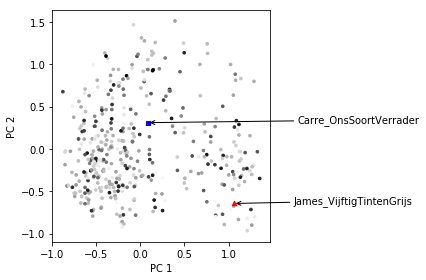

In [24]:
fig, ax = plt.subplots(figsize=(4, 4))
df = pandas.DataFrame(x_comb.copy())
df['label'] = [doc.tags[0].split()[0] for doc in docs]
df['n'] = [doc.tags[0].split()[1] for doc in docs]
df.set_index(['label', 'n'], inplace=True)
centroids = df.mean(axis=0, level='label')
pca = decomposition.PCA(2).fit_transform(centroids)
xdata = pandas.DataFrame(pca, index=centroids.index)
xdata['rating'] = md.loc[centroids.index, 'Literary rating']
xdata['color'] = ['#%02x%02x%02x' % tuple(rgb[:3]) for rgb in 
    plt.cm.Greys(plt.Normalize()(xdata.rating.values), bytes=True)]
selected1 = 'James_VijftigTintenGrijs'
selected2 = 'Carre_OnsSoortVerrader'
xdata.loc[~xdata.index.isin([selected1, selected2]), :].plot.scatter(
        x=xdata.columns[0], y=xdata.columns[1], c=xdata['color'], s=7, ax=ax)
xdata.loc[xdata.index.isin([selected1]), :].plot.scatter(
        x=xdata.columns[0], y=xdata.columns[1], c='r', marker='^', ax=ax)
xdata.loc[xdata.index.isin([selected2]), :].plot.scatter(
        x=xdata.columns[0], y=xdata.columns[1], c='b', marker='s', ax=ax)
ax.annotate(
        selected1, xy=xdata.loc[selected1][:2], xytext=(60, 0), 
        textcoords='offset points', # ha='center', va='bottom',
        arrowprops=dict(arrowstyle='->', color='k'))
ax.annotate(
        selected2, xy=xdata.loc[selected2][:2], xytext=(150, 0), 
        textcoords='offset points', # ha='center', va='bottom',
        arrowprops=dict(arrowstyle='->', color='k'))
ax.set_ylabel('PC 2'); ax.set_xlabel('PC 1'); fig.tight_layout();
fig.savefig('/tmp/exoutlier.pdf', bbox_inches='tight')

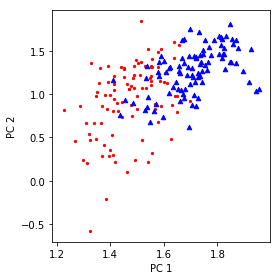

In [25]:
fig, ax = plt.subplots(figsize=(4, 4))
a = 'Royen_Mannentester'
b = 'Moelands_Weerloos'
df = x_comb  # .loc[x_comb.index.str.startswith(a) | x_comb.index.str.startswith(b), :]
pca = decomposition.TruncatedSVD(2).fit_transform(x_comb)
xdata = pandas.DataFrame(pca, index=x_comb.index)
aa = xdata[df.index.str.startswith(a)]
bb = xdata[df.index.str.startswith(b)]
#plt.plot(aa.iloc[:, 0], aa.iloc[:, 1], c='gray')
#plt.plot(bb.iloc[:, 0], bb.iloc[:, 1], c='gray')
aa.plot.scatter(x=xdata.columns[0], y=xdata.columns[1], ax=ax, marker='.', c='r')
#        c=plt.cm.Reds(plt.Normalize()(range(len(aa)))))
bb.plot.scatter(x=xdata.columns[0], y=xdata.columns[1], ax=ax, marker='^', c='b')
#        c=plt.cm.Blues(plt.Normalize()(range(len(bb)))))
ax.set_ylabel('PC 2'); ax.set_xlabel('PC 1'); fig.tight_layout(); # lgd=ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2))
fig.savefig('/tmp/exoverlap.pdf') # bbox_extra_artists=(lgd,), bbox_inches='tight')

Content/topic keywords
------------------

In [26]:
topicnames = pandas.read_table(io.StringIO("""\
Topic	Proportion	Category	Label	Other
t0	1.60%	suspense	spy fiction	
t1	8.80%	other	self-development	
t2	2.70%	literary	family	
t3	0.50%	other	author: Auel	misc
t4	1.50%	theme	sex	
t5	1.10%	suspense	lawsuits	
t6	0.70%	theme	illness	
t7	2.10%	theme	country side	
t8	0.40%	theme	quotation/communication	
t9	2.00%	theme	house	
t10	1.70%	suspense	murder case	
t11	1.60%	theme	children	
t12	1.80%	theme	letters	
t13	0.90%	suspense	investigation	Scandinavian
t14	1.10%	suspense	non-verbal communication	Scandinavian
t15	1.90%	theme	telephony	
t16	1.60%	suspense	interrogatory	Swedish
t17	1.60%	other	author: Den Hollander	
t18	1.10%	theme	maritime	Cussler
t19	0.60%	literary	rulers	
t20	2.60%	romantic	body language	Dutch
t21	1.90%	theme	travel	
t22	2.30%	suspense	murder case	
t23	3.90%	theme	settling down	
t24	0.80%	theme	mystery/archeology	
t25	5.30%	theme	physical attack	
t26	3.40%	literary	nature/life	
t27	1.40%	theme	finance	
t28	0.50%	theme	fantasy	
t29	1.30%	literary	music/performance/misc	Dutch
t30	1.00%	theme	education	
t31	5.80%	theme	(non-)verbal communication	
t32	1.80%	theme	company	
t33	0.60%	theme	hospital	
t34	2.00%	theme	cars	
t35	0.90%	theme	church	
t36	1.50%	theme	international politics	
t37	0.70%	theme	military	
t38	0.60%	literary	slavery & inter-human relations	
t39	1.80%	suspense	weapons	
t40	1.60%	theme	dinner	
t41	1.60%	literary	writers	
t42	1.50%	literary	time, life&death	
t43	0.50%	literary	jewishness	
t44	2.50%	romantic	looks & parties	
t45	3.30%	theme	communication2	
t46	0.70%	other	author: Kinsella/Wickham	?
t47	3.30%	theme	character & bodily descriptions	
t48	6.30%	other	dialogues/colloquial language	
t49	3.10%	theme	home	\
"""), header=0, index_col=0)
topiclongnames = dict(zip(topicnames.index, topicnames.index + ': ' + topicnames.Label))

In [27]:
bottom50 = names[names.str.split(' ').str[0].isin(
        md.sort_values('Literary rating').index[:50])]
top50 = names[names.str.split(' ').str[0].isin(
        md.sort_values('Literary rating').index[-50:])]
x = x_lda.loc[top50, :].mean() - x_lda.loc[bottom50, :].mean()
xx = np.argsort(x)
for n in xx[:5]:
    print(round(x[n], 3), topiclongnames['t%d' % n])
print('...')
for n in xx[-5:]:
    print(round(x[n], 3), topiclongnames['t%d' % n])

-0.07 t44: looks & parties
-0.067 t48: dialogues/colloquial language
-0.052 t31: (non-)verbal communication
-0.048 t46: author: Kinsella/Wickham
-0.044 t23: settling down
...
0.03 t42: time, life&death
0.037 t26: nature/life
0.039 t41: writers
0.039 t1: self-development
0.052 t29: music/performance/misc


In [28]:
bottom50lit = names[names.str.split(' ').str[0].isin(
        md[md.Category == 'Fiction'].sort_values('Literary rating').index[:50])]
top50lit = names[names.str.split(' ').str[0].isin(
        md[md.Category == 'Fiction'].sort_values('Literary rating').index[-50:])]
x = x_lda.loc[top50lit, :].mean() - x_lda.loc[bottom50lit, :].mean()
xx = np.argsort(x)
for n in xx[:5]:
    print(round(x[n], 3), topiclongnames['t%d' % n])
print('...')
for n in xx[-5:]:
    print(round(x[n], 3), topiclongnames['t%d' % n])

-0.043 t31: (non-)verbal communication
-0.031 t3: author: Auel
-0.024 t23: settling down
-0.018 t11: children
-0.01 t44: looks & parties
...
0.012 t30: education
0.012 t1: self-development
0.02 t42: time, life&death
0.035 t41: writers
0.046 t29: music/performance/misc


In [29]:
errors = y_pred - y
under = (y > 5) & (errors < -0.5)
over = (y > 5) & (errors > 0.5)
small = (y > 5) & (errors > -0.5) & (errors < 0.5)
x = x_lda[over].mean() - x_lda[under].mean()
xx = np.argsort(x)
for n in xx[:5]:
    print(round(x[n], 3), topiclongnames['t%d' % n])
print('...')
for n in xx[-5:]:
    print(round(x[n], 3), topiclongnames['t%d' % n])

-0.042 t48: dialogues/colloquial language
-0.023 t25: physical attack
-0.018 t1: self-development
-0.016 t20: body language
-0.015 t31: (non-)verbal communication
...
0.027 t41: writers
0.037 t36: international politics
0.04 t38: slavery & inter-human relations
0.055 t29: music/performance/misc
0.088 t42: time, life&death


Style keywords
--------------

In [30]:
# 1. count keywords in under vs overestimated chunks
keywords = OrderedDict([
        ('male pronouns', ['hij', 'hem']),  # zijn
        ('female pronouns', ['zij', 'ze', 'haar']),
        ('1st/2nd pronouns', ['ik', 'mijn', 'me', 'je', 'jij', 'we']),
        ('perception verbs', 'weet denk vind kijkt voelt vond gevoeld bedoelt herinner besefte'.split()),
        ('dialogue verbs', ['zeg', 'zegt', 'gezegd', 'vraagt', 'zei']),
        ('negation', ['niet', 'geen']),
        ])
df = pandas.DataFrame(index=names)
df.loc[under, 'subset'] = 'underestimated'
df.loc[over, 'subset'] = 'overestimated'
df.loc[small, 'subset'] = 'small error'
for name, words in keywords.items():
    x = pandas.DataFrame(x_uni[:, [unigrams.get_loc(word) for word in words]].toarray(),
                         index=names, columns=words).sum(axis=1)
    df[name] = x
df = pandas.melt(df, id_vars=['subset'], value_vars=df.columns[1:], var_name='category', value_name='count')

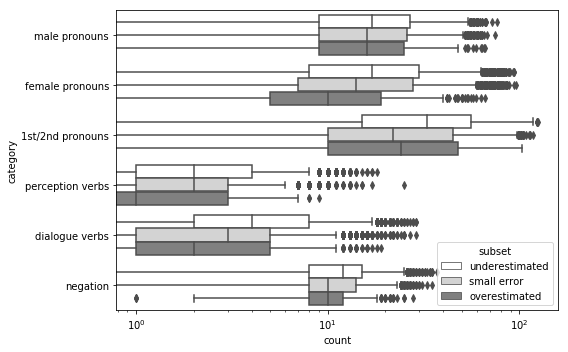

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))
seaborn.boxplot(x='count', y='category', hue='subset', data=df, ax=ax,
                palette={'underestimated': 'white', 'small error': 'lightgray', 'overestimated': 'gray'})
ax.set_xscale('log')
fig.tight_layout()
fig.savefig('/tmp/kwfreqboxplot.pdf')